In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import Dataset,DataLoader

In [139]:
class Self_Attn(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,Q,K,V,mask=None):
    d_k = Q.size(-1)
    score = torch.matmul(Q,K.transpose(-2,-1))/math.sqrt(d_k)

    if mask is not None:
      score = score.masked_fill(mask == 0, float("-inf"))

    attention = torch.softmax(score, dim=-1) # Added dim=-1 for softmax
    output = torch.matmul(attention,V)

    return attention , output

class Multiheadattn(nn.Module):
  def __init__(self,d_model,num_heads):
    super().__init__()

    assert d_model % num_heads == 0

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = self.d_model // self.num_heads

    self.W_Q = nn.Linear(d_model,d_model)
    self.W_k = nn.Linear(d_model,d_model)
    self.W_V = nn.Linear(d_model,d_model)

    self.f_out = nn.Linear(d_model,d_model)

    self.attn = Self_Attn()

  def forward(self,Q,K,V,mask = None):
    batch_size = Q.size(0)

    Q = self.W_Q(Q)
    K = self.W_k(K)
    V = self.W_V(V)

    Q = Q.view(batch_size,-1,self.num_heads,self.d_k).transpose(1,2)
    K = K.view(batch_size,-1,self.num_heads,self.d_k).transpose(1,2)
    V = V.view(batch_size,-1,self.num_heads,self.d_k).transpose(1,2)

    processed_mask = None
    if mask is not None:
      processed_mask = mask.unsqueeze(0).unsqueeze(0)

    attention, out = self.attn(Q,K,V, processed_mask)
    out = out.transpose(1,2).contiguous()
    out = out.view(batch_size,-1,self.d_model)

    return self.f_out(out)

class FeedForward(nn.Module):
  def __init__(self,d_model=2048,d_ff=512):
    super().__init__()
    self.fc = nn.Sequential(nn.Linear(d_model,d_ff),
                            nn.ReLU(),
                            nn.Linear(d_ff,d_model),
                            nn.ReLU())
  def forward(self,x):
      return self.fc(x)

class positional_Embedding(nn.Module):
  def __init__(self,d_model,max_len):
    super().__init__()
    self.d_model = d_model
    self.max_len = max_len

    pe = torch.zeros(max_len,d_model)
    position = torch.arange(0,max_len,step=1).float().unsqueeze(1)
    embedding_index = torch.arange(0,d_model,step=2).float()

    pe[:,0::2] = torch.sin(position/torch.pow(10000,embedding_index/d_model))
    pe[:,1::2] = torch.cos(position/torch.pow(10000,embedding_index/d_model))

    pe = pe.unsqueeze(0)
    self.register_buffer("pe",pe)

  def forward(self,x):
    return x + self.pe[:,:x.size(1)]

class Encoder(nn.Module):
  def __init__(self,d_model,num_heads,d_ff,dropout = 0.1):
    super().__init__()
    self.self_attn = Multiheadattn(d_model,num_heads)
    self.feed_forward = FeedForward(d_model,d_ff)

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)

  def forward(self,x,mask = None):
    # Self-attention sub-layer
    attn_output = self.self_attn(x,x,x,mask)
    x = self.norm1(x + self.dropout1(attn_output))

    # Feed-forward sub-layer
    ff_output = self.feed_forward(x)
    x = self.norm2(x + self.dropout2(ff_output))

    return x

class Decoder(nn.Module):
  def __init__(self,d_model,num_heads,d_ff,dropout = 0.1):
    super().__init__()
    self.self_attn = Multiheadattn(d_model,num_heads) # Masked self-attention
    self.enc_dec_attn = Multiheadattn(d_model,num_heads) # Encoder-decoder attention
    self.feed_forward = FeedForward(d_model,d_ff)

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.norm3 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.dropout3 = nn.Dropout(dropout)

  def forward(self,x,enc_out,src_mask=None,tgt_mask = None):
    # Masked self-attention sub-layer
    self_attn_output = self.self_attn(x,x,x,tgt_mask)
    x = self.norm1(x + self.dropout1(self_attn_output))

    # Encoder-decoder attention sub-layer
    enc_dec_attn_output = self.enc_dec_attn(x,enc_out,enc_out,src_mask)
    x = self.norm2(x + self.dropout2(enc_dec_attn_output))

    # Feed-forward sub-layer
    ff_output = self.feed_forward(x)
    x = self.norm3(x + self.dropout3(ff_output))
    return x

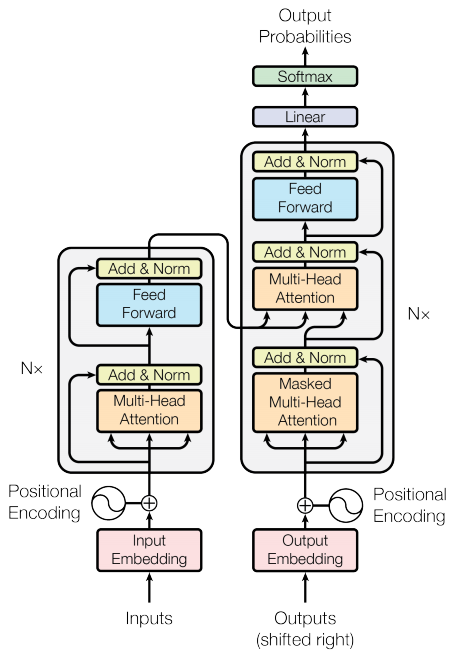

In [73]:
!pip install opendatasets

In [74]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/tanmaypatil3151/english-to-marathi-sentence-dataset")

Skipping, found downloaded files in "./english-to-marathi-sentence-dataset" (use force=True to force download)


In [137]:
import pandas as pd

data = pd.read_csv("/content/english-to-marathi-sentence-dataset/data.csv")


In [138]:
# padding ,unknown , start and end of a sentence with numeric values in both dictionary


english_vocab = {"<pad>":0,"<unk>":1,"<sos>":2,"<eos>":3}
marathi_vocab = {"<pad>":0,"<unk>":1,"<sos>":2,"<eos>":3}
def tokenize(text):
  text = text.replace("?","")
  text = text.replace("!","")
  text = text.replace(".","")
  text = text.lower()
  return text.split()

def making_vocab(row):

  tokenized_eng = tokenize(row["English"])
  tokenized_mar = tokenize(row["Marathi"])

  for word in tokenized_eng:
    if word not in english_vocab:
      if len(english_vocab)<12000:
        english_vocab[word] = len(english_vocab)

  for word in tokenized_mar:
    if word not in marathi_vocab:
      if len(marathi_vocab)<12000:
        marathi_vocab[word] = len(marathi_vocab)

data.apply(making_vocab,axis=1)

def text_to_index(text,vocab):
  max_sequence_length = 8

  indexed = [english_vocab["<sos>"]]
  tokens = tokenize(text)

  for word in tokens:
    if len(indexed) < max_sequence_length - 1:
      if word in vocab:
        indexed.append(vocab[word])
      else:
        indexed.append(vocab["<unk>"])
    else:
      break

  indexed.append(english_vocab["<eos>"])

  # Padding the encodding to max_sequence_length if still too short
  while len(indexed) < max_sequence_length:
    indexed.append(english_vocab["<pad>"])

  indexed = indexed[:max_sequence_length]

  return indexed


In [121]:
#test
print(text_to_index("hello this is cool what is your name i am fine ",english_vocab))

[2, 14, 123, 245, 54, 218, 245, 3]


In [122]:

class Customdataset(Dataset):
  def __init__(self,df,eng,mar):
    self.df = df
    self.eng = eng
    self.mar = mar

  def __len__(self):
    return len(self.eng)

  def __getitem__(self,index):
    eng = text_to_index(self.df.iloc[index]["English"],english_vocab)
    mar = text_to_index(self.df.iloc[index]["Marathi"],marathi_vocab)

    return torch.tensor(eng),torch.tensor(mar)


In [123]:
dataset = Customdataset(data,english_vocab.values(),marathi_vocab.values())
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)
a,b = dataset[7]
print(a,b)
print(len(english_vocab))

tensor([2, 7, 3, 0, 0, 0, 0, 0]) tensor([2, 7, 3, 0, 0, 0, 0, 0])
12000


In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [126]:
class Transformer(nn.Module):
  def __init__(self,src_vocab,tgt_vocab,num_heads=8,d_model = 512 , d_ff = 2048,num_layers = 6,max_len = 12000):
    super().__init__()
    self.src_embedding = nn.Embedding(src_vocab,d_model)
    self.tgt_embedding = nn.Embedding(tgt_vocab,d_model)

    self.positional_Encoding = positional_Embedding(d_model, max_len)

    self.Encoder = nn.ModuleList([Encoder(d_model,num_heads,d_ff) for _ in range(num_layers)])

    self.Decoder = nn.ModuleList([Decoder(d_model,num_heads,d_ff) for _ in range(num_layers)])

    self.linear = nn.Linear(d_model,tgt_vocab)

  def forward(self,src,tgt,src_mask=None,tgt_mask=None):
    src = self.positional_Encoding(self.src_embedding(src))
    tgt = self.positional_Encoding(self.tgt_embedding(tgt))

    for layers in self.Encoder:
      src = layers(src,src_mask)

    for layers in self.Decoder:
      tgt = layers(tgt,src,src_mask,tgt_mask)

    return self.linear(tgt)

def Casual_mask(size,device):
  mask = torch.tril(torch.ones(size,size)).to(device)
  return mask

In [127]:
Tmodel = Transformer(torch.tensor(len(english_vocab)),torch.tensor(len(marathi_vocab)),d_model=64).to(device)

optimizer = optim.Adam(Tmodel.parameters(),lr=0.0001)
"""for name , data in Transformer.named_parameters():
  print(name)
  print(data)"""

criterion = nn.CrossEntropyLoss(ignore_index=marathi_vocab["<pad>"])
epochs=50
for epoch in range(epochs):
  total_loss = 0
  for eng,mar in dataloader:
    optimizer.zero_grad()
    eng = eng.clone().detach().to(device)
    mar = mar.clone().detach().to(device)
    mar_input = mar[:,:-1]
    mar_target = mar[:,1:]
    tgt_mask = Casual_mask(mar_input.shape[1],device)
    output = Tmodel(eng,mar_input,tgt_mask=tgt_mask)
    loss = criterion(output.reshape(-1,output.shape[2]),mar_target.reshape(-1))
    loss.backward()
    optimizer.step()

    total_loss +=loss.item()
  print(f"Epoch--> {epoch+1}, Total_loss = {total_loss/len(dataloader)}")



Epoch--> 1, Total_loss = 6.982052946726481
Epoch--> 2, Total_loss = 4.97931090037028
Epoch--> 3, Total_loss = 4.256554838816325
Epoch--> 4, Total_loss = 3.863334000269572
Epoch--> 5, Total_loss = 3.5680760434468586
Epoch--> 6, Total_loss = 3.3351691951751707
Epoch--> 7, Total_loss = 3.1231257133483887
Epoch--> 8, Total_loss = 2.941292284011841
Epoch--> 9, Total_loss = 2.7731757043202716
Epoch--> 10, Total_loss = 2.613081511179606
Epoch--> 11, Total_loss = 2.469330604871114
Epoch--> 12, Total_loss = 2.3352130613327025
Epoch--> 13, Total_loss = 2.2061043634414674
Epoch--> 14, Total_loss = 2.0874510526657106
Epoch--> 15, Total_loss = 1.9693309208552043
Epoch--> 16, Total_loss = 1.864349905649821
Epoch--> 17, Total_loss = 1.7611041854222615
Epoch--> 18, Total_loss = 1.6603481448491415
Epoch--> 19, Total_loss = 1.5697052539189658
Epoch--> 20, Total_loss = 1.4778140128453572
Epoch--> 21, Total_loss = 1.4030002899169922
Epoch--> 22, Total_loss = 1.3169242115020752
Epoch--> 23, Total_loss = 1.

In [128]:
def translate_sentence(model, sentence, english_vocab, marathi_vocab, max_len=8, device='cpu'):
    model.eval() # Set the model to evaluation mode

    # Tokenize and index the English input sentence
    tokenized_eng = tokenize(sentence)
    indexed_eng = [english_vocab["<sos>"]]
    for word in tokenized_eng:
        indexed_eng.append(english_vocab.get(word, english_vocab["<unk>"])) # Use .get for robustness
    indexed_eng.append(english_vocab["<eos>"])

    # Pad the English sequence to max_len if shorter, or truncate if longer
    if len(indexed_eng) < max_len:
        indexed_eng += [english_vocab["<pad>"]] * (max_len - len(indexed_eng))
    else:
        indexed_eng = indexed_eng[:max_len-1] + [english_vocab["<eos>"]]

    src_tensor = torch.tensor(indexed_eng).unsqueeze(0).to(device) # Add batch dimension

    # Initialize the target sequence with <sos>
    trg_indexes = [marathi_vocab["<sos>"]]

    for i in range(max_len - 1):
        trg_tensor = torch.tensor(trg_indexes).unsqueeze(0).to(device)

        # Create a causal mask for the target sequence
        tgt_mask = Casual_mask(trg_tensor.shape[1], device)

        with torch.no_grad():
            output = model(src_tensor, trg_tensor, src_mask=None, tgt_mask=tgt_mask)

        # Get the next predicted token
        pred_token = output.argmax(2)[:,-1].item() # Get the last token's prediction
        trg_indexes.append(pred_token)

        if pred_token == marathi_vocab["<eos>"]:
            break

    # Convert indices back to words
    marathi_itos = {idx: word for word, idx in marathi_vocab.items()}
    translated_tokens = [marathi_itos[idx] for idx in trg_indexes]

    # Remove <sos>, <eos> and <pad> tokens for cleaner output
    final_translation = []
    for token in translated_tokens:
        if token not in ['<sos>', '<eos>', '<pad>']:
            final_translation.append(token)

    return ' '.join(final_translation)

In [143]:
# Example usage -
sentence_to_translate = "what work do you do"

translated_marathi = translate_sentence(Tmodel, sentence_to_translate, english_vocab, marathi_vocab, max_len=8, device=device)
print(f"English: {sentence_to_translate}")
print(f"Marathi: {translated_marathi}")


English: what work do you do
Marathi: तुला काय करता
